# Generate CMIP Historical Forcing

In this notebook we will show you how to obtain historical forcing from the CMIP6 project.
CMIP datasets can be found [here](https://aims2.llnl.gov/nodes), sometimes their servers are unreachable :(
CMIP has these climate scenarios based on carbon emissions, go [here](https://climate-scenarios.canada.ca/?page=cmip6-overview-notes) (or [here](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios)) to find out more!

We are going to need multiple things again:
- shapefile of the region of interest
- a time-window
- experiment: in this case 'historic'
- dataset
- an ensemble member
- grid

Not all CMIP climate scenarios are available on all servers.
This means that you have to carefully choose the server, **disclaimer** that means that the datasets chosen here can also be faulty.
The amount of ensemble members also vary, these are handy if you want to get a statistically better result.
Grid options define how data is spatially represented—either on the model’s native grid or a regridded format (e.g., regular lat-lon). This affects data compatibility, resolution, and comparability between models.

| Grid Label | Description                                | Typical Use Case                           |
|------------|--------------------------------------------|--------------------------------------------|
| gn         | Native grid (often irregular, model-native)| Our default, it will follow your shapefile |
| gr         | Regular 1x1° interpolated lat-lon grid     | Commonly used for comparison & analysis    |
| gr1        | Alternative interpolated grid (1°x1°)      | Sometimes used as standardized grid        |
| gr025      | High-resolution grid (0.25°x0.25°)         | Fine-scale analysis, less common           |

In the notebook of the future forcing of CMIP I will show you what datasets/ensembles are available at the time of writing this guide (July 2025).

In [1]:
# Ignore user warnings :)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Required dependencies
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import matplotlib.pyplot as plt

import ewatercycle
import ewatercycle.forcing

So let us start with the region and the time-window + the paths we will be using:

In [2]:
# The name of the shapefile
shape_file_name = "camelsgb_33039"  # river: Bedford Ouse at Roxton, England

# The path to the shapefiles
shapefile_path =  Path.home() / "getting-started/book/some_content/forcing/shapefiles" / f"{shape_file_name}.shp"  # check this directory yourself!

# The time-window of the experiment
experiment_start_date = "2000-08-01T00:00:00Z"
experiment_end_date = "2005-08-31T00:00:00Z"

# The path save directory of the CMIP data
forcing_path_CMIP = Path.home() / "forcing" / shape_file_name / "CMIP6"   # we do not use historical here, so we can use this as a default save path later on
forcing_path_CMIP.mkdir(exist_ok=True)

## Gather the CMIP historical forcing

In [3]:
cmip_historical =  {
   'project': 'CMIP6',
   'exp': 'historical',
   'dataset': 'MPI-ESM1-2-HR',
   "ensemble": 'r1i1p1f1',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_historical,
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_CMIP / "historical",
)

Normally you can look at the cmip forcing now, but we will first show you how to load the data and move on from there:

In [4]:
# Load the generated historical data
historical_CMIP_location = forcing_path_CMIP / "historical" / "work" / "diagnostic" / "script"
historical_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historical_CMIP_location)

In [5]:
print(historical_CMIP_forcing)

LumpedMakkinkForcing(
    start_time='2000-08-01T00:00:00Z',
    end_time='2005-08-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/historical/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/historical/work/diagnostic/script/camelsgb_33039.s
hp'),
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_pr_gn_2000-2005.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_tas_gn_2000-2005.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_rsds_gn_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

So the LumpedMakkinkForcing stores the following:
1. pr: precipitation
2. tas: temperature
3. rsds: incoming shortwave radiation
4. evspsblpot: potential evaporation (note that this is calculated, using Makkink)

## The data

We can easily plot the data now!

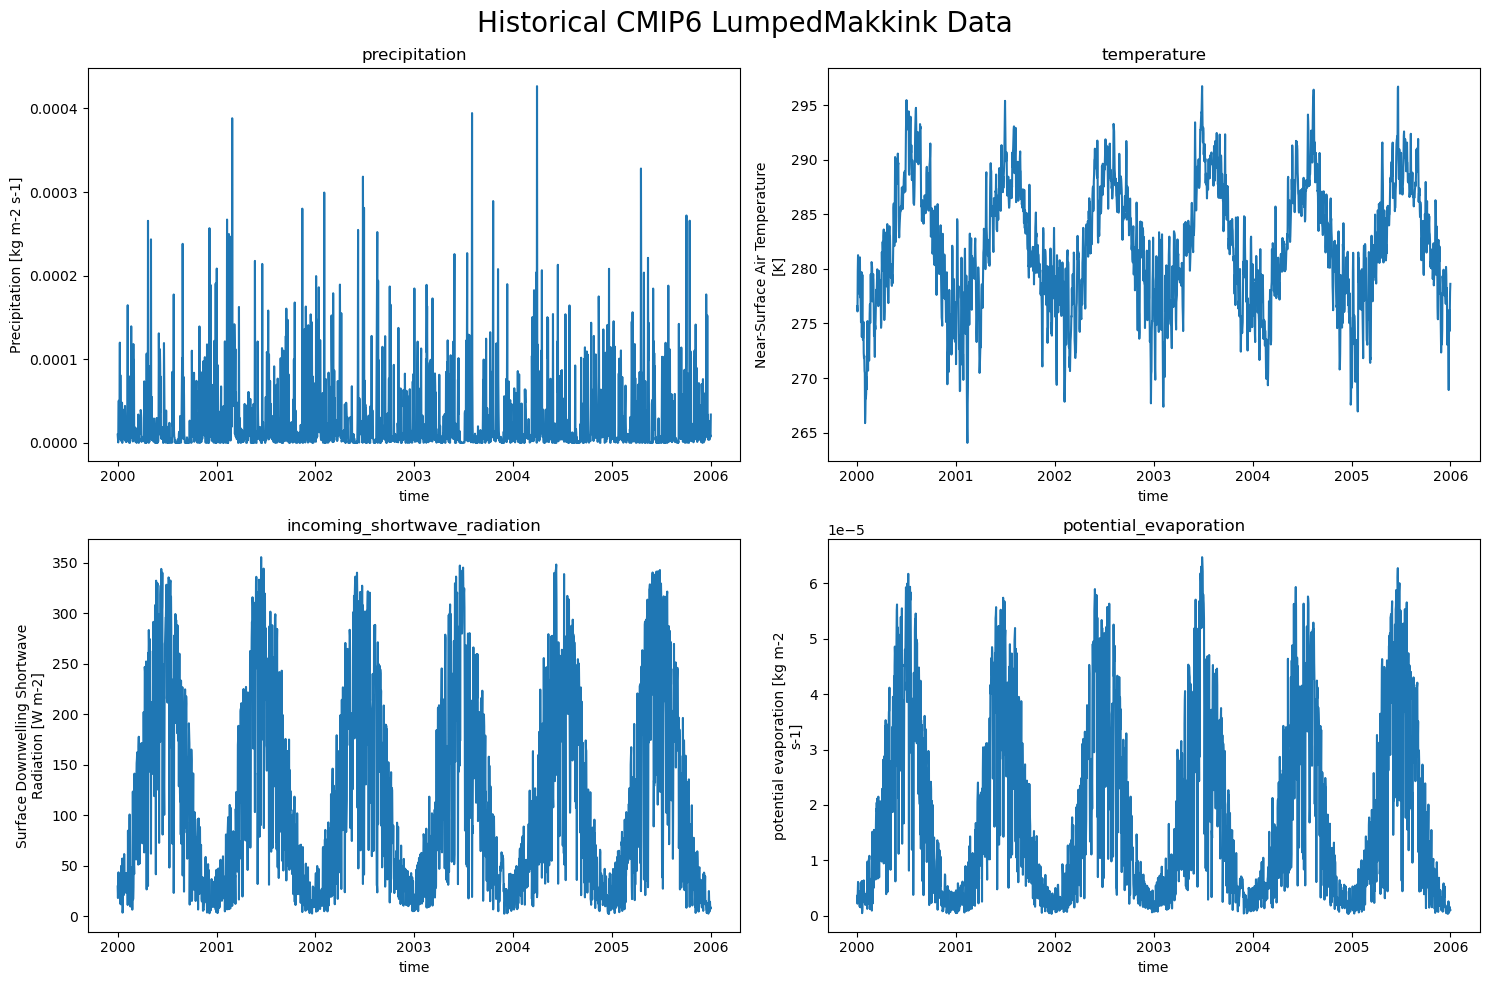

In [6]:
historical_CMIP_data = {'precipitation pr': xr.open_dataset(historical_CMIP_forcing['pr']),
             'temperature tas': xr.open_dataset(historical_CMIP_forcing['tas']),
             'incoming_shortwave_radiation rsds': xr.open_dataset(historical_CMIP_forcing['rsds']),
             'potential_evaporation evspsblpot': xr.open_dataset(historical_CMIP_forcing['evspsblpot'])
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for name, data in historical_CMIP_data.items():
    plt.subplot(2,2, plot_counter)
    data[name.split(" ")[-1]].plot()
    plt.title(f"{name.split(" ")[0]}")
    plot_counter += 1

plt.suptitle("Historical CMIP6 LumpedMakkink Data", fontsize=20)
plt.tight_layout()